# Find Lane Markings

### Define a class to receive the characteristics of each line detection

In [1]:
import numpy as np

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self,image_shape):
        self.maxx = image_shape[0]
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        #self.recent_xfitted = [] 
        #self.recent_yfitted = []
        self.recent_fits = []
        #average x values of the fitted line over the last n iterations
        #self.bestx = None     
        #self.besty = None
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        self.radius_of_curvature_array = []
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        self.line_base_pos_array = []
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    #getters and setters
        
    def set_line(self, pointsx, pointsy):
        assert (type(pointsy) is np.ndarray) and (type(pointsx) == np.ndarray)
        assert pointsy.size > 0
 
        self.allx = pointsx
        self.ally = pointsy
        
        if self.allx.size > 0:
            self.detected=True
            self.current_fit = np.polyfit(self.ally, self.allx, 2)
            self.radius_of_curvature_array.append(self.__calculate_curvature())
            if len(self.radius_of_curvature_array) >=15:
                self.radius_of_curvature = np.mean(self.radius_of_curvature_array)
                self.radius_of_curvature_array.pop(0)
            self.line_base_pos_array.append(self.__calculate_dist())
            if len(self.line_base_pos_array) >= 15:
                self.line_base_pos= np.mean(self.line_base_pos_array)
                self.line_base_pos_array.pop(0)
            
            if self.best_fit is None :
                self.best_fit = self.current_fit
        else:
            self.detected=False
            self.current_fit = [np.array([False])]
            self.radius_of_curvature = None   
            self.line_base_pos = None
            self.best_fit = None
    
    def get_curvature(self):
        return self.radius_of_curvature
    
    def get_distance(self):
        return self.line_base_pos
            
    def get_fit(self):
        return self.best_fit
        #return self.current_fit
    
    #predicate methods
    def is_detected(self):
        return self.detected
    
    #other public methods
    
    def is_similar_to(self, other_line, curv_thresh = 500, dist_offset =0.5):
        if self.get_curvature() is not None and other_line.get_curvature() is not None:
            similar_curvatures = np.abs(self.get_curvature() - other_line.get_curvature()) <= curv_thresh
            similar_distances = np.abs(self.get_distance()) - np.abs(other_line.get_distance()) <= dist_offset
            return similar_curvatures and similar_distances
        else : return False
    
    #appends x values to x values list, refreshes the moving average of the polynomial coefficients
    def update_average(self):
        #append y values
        self.recent_fits.append(self.current_fit)
        if len(self.recent_fits) > 15:
            remove = self.recent_fits.pop(0)
        if len(self.recent_fits)>1:
            self.best_fit = np.mean(self.recent_fits,axis=0)
        else: 
            self.best_fit = self.current_fit
    
    #private methods
    
    def __calculate_curvature(self):
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        fit = np.polyfit(self.ally*ym_per_pix, self.allx*xm_per_pix, 2)
        y_eval = np.max(self.ally)
        curvature_radius = ((1 + (2*fit[0]*y_eval*ym_per_pix + fit[1])**2)**1.5) / np.absolute(2*fit[0])
        return curvature_radius
    
    def __calculate_dist(self):
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        midpoint = xm_per_pix*self.maxx/2  #midpoint assuming camera is centered
        
        #get the x value for the lowest y in the image (the one with the highest y value)
        sort_indices= self.ally.argsort()
        x=self.allx[sort_indices]
        return xm_per_pix*x[-1] - midpoint
        


### Function that corrects distorsion
returns: undistorted image

In [2]:
import glob
#correct distorsion

def calibrate(calibration_images_path='camera_cal/cal*.jpg'):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(calibration_images_path)

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return ret, mtx, dist

def undistort(img,mtx,dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

### Function that applies a series of thresholds to an image to detect what seems to be lane markings
returns: a filtered binary image

In [3]:
#apply thresholds

#apply a simple HSV threshold, leveraging H layer. 
def hls_thresh(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    thresh = {'L': (180,255),
              'S': (180,255)}  
    
    S = hls[:,:,2]
    L = hls[:,:,1]

    binary_S = np.zeros_like(S)
    binary_S[(S > thresh['S'][0]) & (S <= thresh['S'][1])] = 1
    
    binary_L = np.zeros_like(L)
    binary_L[(L > thresh['L'][0]) & (L <= thresh['L'][1])] = 1
    
    combined_hls = np.zeros_like(S)
    combined_hls[(binary_S == 1) | (binary_L == 1)] = 1 
    
    return combined_hls

def abs_sobel_thresh(img, orient='x', thresh= [0,255], sobel_kernel=3):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x' : 
        gradient = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y' :
        gradient= cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else: 
        raise ValueError('orient must be either x or y')
        
    # 3) Take the absolute value of the derivative or gradient
    img= np.absolute(gradient)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    img = np.uint(255*img/np.max(img))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    grad_binary= np.zeros_like(img)
    grad_binary[(img >=  thresh[0]) & (img <= thresh[1])] = 1
    
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    return grad_binary

#returns: a binary image with emphasis on lane lines


### Function that takes a perspective binary image and returns a birdseye version
returns: birdseye view of lane markings (binary) 

In [4]:
#apply perspective transform

def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped,M,Minv
#returns: a birds eye version of the binary

### Takes a birdseye view and finds lane patterns using sample window search, returns a list of right and left points to be used for polynomial fit
returns: x and y points for left and right lane markings

In [5]:
#when the image is new or when the markings have been lost from previous frame, apply sample window search to fit a polynomial 
#returns an image with lane markings drawn on original image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2


def find_points_using_windows(binary_warped, nwindows = 9, margin = 100, minpix = 50):

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    return leftx,lefty,rightx,righty


### Function that uses existing polynomial to find lane markings in a region around polynomial
returns a new polynomial

In [6]:
# refresh polynomial
# returns polynomial

def refresh_polynomials(left_fit, right_fit, binary_warped):

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx,lefty,rightx,righty
    


## Pipeline applying transformations to image frames

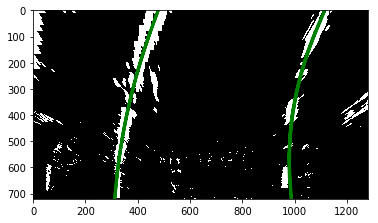

In [7]:
# Read in a thresholded image for now...
warped = mpimg.imread('warped_example.jpg')
plt.figure()
plt.imshow(warped,cmap='gray')

right_L = Line(warped.shape)
left_L = Line(warped.shape)

def get_lane_lines(warped,left_line,right_line,nwindows = 9, margin = 100, minpix = 50):
    # window settings
    #window_width = 50 
    #window_height = 80 # Break image into 9 vertical layers since image height is 720
    #margin = 100 # How much to slide left and right for searching

    #find lane markings and fit polynomial 
    #if no existing or valid polynomial : use window slide
    if not right_line.is_detected() or not left_line.is_detected(): 
        # Fit a second order polynomial to each
        leftx,lefty,rightx,righty= find_points_using_windows(warped,nwindows, margin, minpix=50)  

    else : 
        left_fit = left_line.get_fit()
        right_fit = right_line.get_fit()

        leftx,lefty,rightx,righty= refresh_polynomials(left_fit,right_fit,warped)
        if leftx.size ==0 or rightx.size == 0:
            leftx,lefty,rightx,righty=find_points_using_windows(warped,nwindows, margin, minpix=50)
            
    left_line.set_line(leftx,lefty)
    right_line.set_line(rightx,righty)

    left_fit = left_line.get_fit()
    right_fit = right_line.get_fit()
  
    return left_line, right_line

left_line,right_line=get_lane_lines(warped,left_L,right_L)

#get data for plot
ploty = left_line.ally
left_fit = left_line.get_fit()
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = right_line.get_fit()
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
# Plot up the data
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.gca().invert_yaxis() # to visualize as we do the images

#print('left line dist: ',left_line.get_distance(),'\nright line dist: ',right_line.get_distance())
#print('is similar: ',right_line.is_similar_to(left_line))
#calculate radius of curvature

#return radius of curvature

#unapply perspective transform and visual representation of result and append curvature results to image
#returns an image with lane markings drawn on original image

#display frames

(720, 1280)


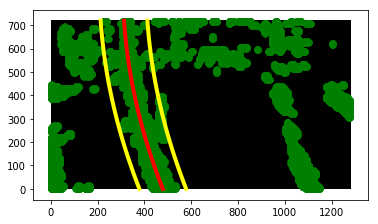

In [8]:
#test for mentoring purposes
plt.imshow(warped, cmap='gray')
leftx,lefty,rightx,righty= find_points_using_windows(warped,9, 100, minpix=50)
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
print(warped.shape)
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))

px=  (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2])
plt.plot(px,nonzeroy, color='red', linewidth = 4)
plt.plot(px+100,nonzeroy, color='yellow', linewidth = 4)
plt.plot(px-100,nonzeroy, color='yellow', linewidth = 4)
plt.scatter([nonzerox],[nonzeroy],color='green', linewidth = .1)
plt.gca().invert_yaxis()

#select pixels within the yellow lines
#fit a new polynomial to these pixels

In [9]:
#find calibration matrix
ret, mtx, dist = calibrate(calibration_images_path='camera_cal/cal*.jpg')

In [11]:
### test all functions

#get a random frame from the video to test : 
cap = cv2.VideoCapture('./project_video.mp4')
width= cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
fps = cap.get(cv2.CAP_PROP_FPS)
length = cap.get(cv2.CAP_PROP_FRAME_COUNT)

try:
    assert length > 0 
except AssertionError as e :
    raise ValueError('the length of the video file appears to be zero')

#pick and display a random frame
#fr = np.random.randint(length)
fr =200
cap.set(cv2.CAP_PROP_POS_FRAMES,fr)
ret, frame= cap.read()
if ret:
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title('original image')
    plt.axis('off')
cap.release()

def image_pipeline(frame,left_marker,right_marker, debug=False):
    #apply pipeline to random frame, print every step
    #1. undistort 
   
    frame=  undistort(frame,mtx,dist)
    
    #display original image
    if debug: 
        plt.figure()
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.imsave('undistorted.png',cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title('undistorted image')

    #threshold
    binary_hls=  hls_thresh(frame)     #apply filter based on HLS color space
    binary_dir_thresh = abs_sobel_thresh(frame, thresh=[20,100], sobel_kernel=15)  #apply directional threshold
    binary_image = np.zeros_like(binary_hls)  #merge two previous filters
    binary_image[(binary_hls == 1) | (binary_dir_thresh == 1)] = 1 
    binary_image=  binary_image * 255
    
    #display thresholded image
    if debug: 
        plt.figure()
        plt.imshow(binary_image,cmap='gray')
        plt.axis('off')
        plt.title('thresholded binary image')
        
    #perspective transform
    img_size = binary_image.shape[::-1]
    src= np.float32([[600,450],[700,450],[200,img_size[1]],[1200,img_size[1]]])
    
    dx = img_size[0] / 5
    dy=5
    dst = np.float32([[0+dx,0+dy],
        [img_size[0]-dx,0+dy],
        [0+dx,img_size[1]-dy],
        [img_size[0]-dx,img_size[1]-dy]])
    
    warped_binary,M,Minv= warper(binary_image, src, dst)
    print(src,dst)
    #display warped image with source and destination lines overlaid
    if debug:
        black=np.dstack((binary_image,binary_image,binary_image))
        pts = src.reshape((-1,1,2))
        cv2.polylines(black,[pts.astype(np.int32)[np.array([0,1,3,2])]],True,(0,255,255),5)
        pts = dst.reshape((-1,1,2))
        cv2.polylines(black,[pts.astype(np.int32)[np.array([0,1,3,2])]],True,(255,0,0),5)
    
        plt.figure()
        plt.imshow(black)
        plt.title('source and destination')

        plt.figure()
        plt.imshow(warped_binary,cmap='gray')
        plt.title('warped result')

    #curvature calculation
    
    ## This is where the lane marking object get updated
    left_line,right_line=get_lane_lines(warped_binary,left_marker,right_marker)
    #run sanity checks 
    if left_marker.is_similar_to(right_marker): 
        #print("marker was updated")
        left_marker.update_average()
        right_marker.update_average()
    
    
    
    #plot lines on warped binary
    
    ploty = left_line.ally
    left_fit = left_line.get_fit()
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = right_line.get_fit()
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    if debug:
        plt.plot(left_fitx, ploty, color='green', linewidth=3)
        plt.plot(right_fitx, ploty, color='green', linewidth=3)
        plt.xlim(0, 1280)
        plt.ylim(0, 720)
        plt.gca().invert_yaxis() # to visualize as we do the images

    #unwrap and draw green zone on original frame
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (frame.shape[1], frame.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(frame, 1, newwarp, 0.3, 0)
    
    if debug:
        plt.figure()
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('unwarped result')
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    if right_marker.get_curvature() is not None:
        cv2.putText(result,'Curvature: '+format(right_marker.get_curvature(),'2.0f')+'m',(10,100), font, 2,(255,255,255),2,cv2.LINE_AA)
    if left_marker.get_distance() is not None and right_marker.get_distance() is not None:
        cv2.putText(result,'Distance L: '+format(left_marker.get_distance(),'2.2f')+'m R:'+format(right_marker.get_distance(),'2.2f')+'m',(10,200), font, 2,(255,255,255),2,cv2.LINE_AA)
    return result
    
#rl = Line(frame.shape[0:2][::-1])
#ll = Line(frame.shape[0:2][::-1])
img = image_pipeline(frame,ll,rl,debug=True)
plt.figure()
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))


ValueError: the length of the video file appears to be zero

### Process video

In [ ]:
print(rl.recent_fits)
print(len(ll.recent_fits))
print(rl.best_fit)
print(rl.current_fit)

In [ ]:
from moviepy.editor import VideoFileClip

#todo : it is not convenient not to be able to pass arguments to the function that processes the frame... find another way to edit video ???
rl = Line(frame.shape[0:2][::-1])
ll = Line(frame.shape[0:2][::-1])
def process_image(frame):
    return image_pipeline(frame,ll,rl,debug=False)
    
video_output = 'video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(6,8)
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

### Display video inline

In [ ]:
from IPython.display import HTML
#play result
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))